# Objective:

Train the model to rank the text comments **in order of popularity.**

Data sctructure:
- A separate line in the file is a valid JSON with a sample
- Each JSON has a text field with the text of the post and an array of 5 elements
- Each element of the array is a dictionary with the keys text with the comment text and score with the ranking position (0 corresponds to the most popular comment, 4 to the least popular)
- The score field in the test file has null

While validation - we look at the **NDCG** metric for the test dataset.



In [7]:
import json
import pandas as pd
import numpy as np

from sklearn.metrics import ndcg_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import ndcg_score
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import statistics

# Load data:

In [8]:
#-------------------------------------------------#
# Load training data
#-------------------------------------------------#

train_data=[]
with open('/Users/nikitaborisov/Desktop/CupIT2023-/ranking_train.jsonl', 'r') as f:
    for line in f:
        sample = json.loads(line.strip())
        train_data.append(sample)  


In [9]:
#-------------------------------------------------#
# Load test data
#-------------------------------------------------#

test_data=[]
with open('/Users/nikitaborisov/Desktop/CupIT2023-/ranking_test.jsonl', 'r') as f:
    for line in f:
        sample = json.loads(line.strip())
        test_data.append(sample) 


# EDA:

In [10]:
# Extract  fields
train_texts = [data["text"] for data in train_data]
train_comments = [comment["text"] for data in train_data for comment in data["comments"]]
train_scores = [comment["score"] for data in train_data for comment in data["comments"]]


In [11]:
# basic statistics
num_samples = len(train_data)
text_lengths = [len(text) for text in train_texts]
comment_lengths = [len(comment) for comment in train_comments]
score_counts = [train_scores.count(i) for i in range(5)]


Text length stats: mean=46, std=17
Comment length stats: mean=523, std=595


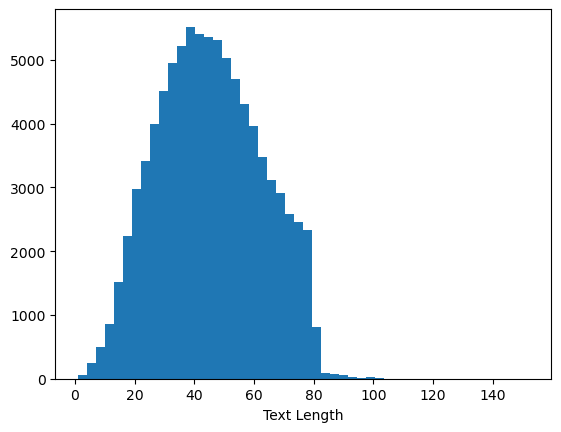

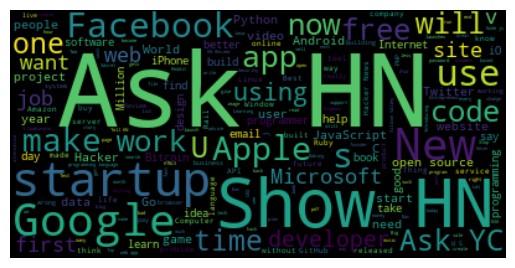

In [12]:
print("Text length stats: mean={}, std={}".format(round(sum(text_lengths) / num_samples), round(statistics.stdev(text_lengths))))
print("Comment length stats: mean={}, std={}".format(round(sum(comment_lengths) / len(train_comments)), round(statistics.stdev(comment_lengths))))
plt.hist(text_lengths, bins=50)
plt.xlabel("Text Length")
plt.show()
wordcloud = WordCloud().generate(" ".join(train_texts))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


# Train and validate:

###  We used the LinearRegression and TfidfVectorizer as feature_extraction.text.

As a evaluation metric, we used Normalized Discounted Cumulative Gain (NDCG). 

In [13]:
import json
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import ndcg_score

# Extract features train data
X_train = []
y_train = []
for sample in train_data:
    post = sample['text']
    comments = sample['comments']
    comment_texts = [comment['text'] for comment in comments]
    comment_scores = [comment['score'] for comment in comments]
    X_train.append(post + ' '.join(comment_texts))
    y_train.append(comment_scores)

# Extract features from test 
X_test = []
for sample in test_data:
    post = sample['text']
    comments = sample['comments']
    comment_texts = [comment['text'] for comment in comments]
    X_test.append(post + ' '.join(comment_texts))

# Vectorize text 
vectorizer = TfidfVectorizer() # vectorizes them using TF-IDF
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# predict 
y_test_pred = model.predict(X_test)

# Fill null score values in test with predicted values
for i in range(len(test_data)):
    for j in range(5):
        if test_data[i]['comments'][j]['score'] is None:
            test_data[i]['comments'][j]['score'] = int(y_test_pred[i][::-1][j])

# Compute NDCG  on test 
y_test_true = [[comment['score'] for comment in sample['comments']] for sample in test_data]
ndcg = ndcg_score(y_test_true, y_test_pred, k=5)

print('NDCG score on test data:', ndcg)


NDCG score on test data: 0.6104173580303227


In [14]:
# Write updated test sample to file
with open('ranking_test.jsonl', 'w') as f:
    for line in test_data:
        f.write(json.dumps(line) + '\n')